# Probabilidad

Este cuaderno IPy actúa como material de apoyo para los temas tratados en el **Capítulo 13 Cuantificación de la incertidumbre**, **Capítulo 14 Razonamiento probabilístico**, **Capítulo 15 Razonamiento probabilístico a lo largo del tiempo**, **Capítulo 16 Toma de decisiones simples** y partes del **Capítulo 25 Robótica** del libro* Inteligencia artificial: un enfoque moderno*. Este cuaderno utiliza las implementaciones del módulo probabilidad.py. Importemos todo desde el módulo de probabilidad. Podría resultar útil ver el código fuente de algunas de nuestras implementaciones. Consulte el archivo IPy introductorio para obtener más detalles sobre cómo hacerlo.

In [1]:
from probability import *
from utils import print_table
from notebook import psource, pseudocode, heatmap

## CONTENIDO
- Distribución de probabilidad
- Distribución de probabilidad conjunta
- Inferencia utilizando distribuciones conjuntas completas.
<br>
- Redes Bayesianas
- Nodo Bayes
-BayesNet
- Inferencia exacta en redes bayesianas
- Enumeración
- Eliminación de variables
- Inferencia aproximada en redes bayesianas
- Muestra previa
- Muestreo de rechazo
- Ponderación de probabilidad
- Muestreo de Gibbs
<br>
- Modelos ocultos de Markov
- Inferencia en modelos ocultos de Markov
- Hacia adelante hacia atrás
- Suavizado de retraso fijo
- Filtrado de partículas
<br>
<br>
- Localización de Montecarlo
- Agente teórico de decisiones
- Agente de recopilación de información

## DISTRIBUCIÓN DE PROBABILIDAD

Comencemos especificando distribuciones de probabilidad discretas. La clase **ProbDist** define una distribución de probabilidad discreta. Nombramos nuestra variable aleatoria y luego asignamos probabilidades a los diferentes valores de la variable aleatoria. Asignar probabilidades a los valores funciona de manera similar a usar un diccionario donde las claves son el Valor y le asignamos la probabilidad. Esto es posible gracias a los métodos mágicos **_ _getitem_ _** y **_ _setitem_ _** que almacenan las probabilidades en el problema del objeto. Puede mantener abierta la ventana de origen mientras juega con el resto del código para comprenderlo mejor.

In [2]:
psource(ProbDist)

In [3]:
p = ProbDist('Flip')
p['H'], p['T'] = 0.25, 0.75
p['T']

0.75

El primer parámetro del constructor **varname** tiene un valor predeterminado de '?'. Entonces, si no se pasa el nombre, el valor predeterminado es ?. El argumento de la palabra clave **freqs** puede ser un diccionario de valores de una variable aleatoria: probabilidad. Luego, estos se normalizan de modo que los valores de probabilidad sumen 1 utilizando el método **normalizar**.

In [4]:
p = ProbDist(freqs={'low': 125, 'medium': 375, 'high': 500})
p.varname

'?'

In [5]:
(p['low'], p['medium'], p['high'])

(0.125, 0.375, 0.5)

Además de **prob** y **varname**, el objeto también realiza un seguimiento por separado de todos los valores de la distribución en una lista llamada **valores**. Cada vez que a un nuevo valor se le asigna una probabilidad, se agrega a esta lista. Esto se hace dentro del método **_ _setitem_ _**.

In [6]:
p.values

['low', 'medium', 'high']

La distribución por defecto no se normaliza si los valores se agregan de forma incremental. Aún podemos forzar la normalización invocando el método **normalizar**.

In [7]:
p = ProbDist('Y')
p['Cat'] = 50
p['Dog'] = 114
p['Mice'] = 64
(p['Cat'], p['Dog'], p['Mice'])

(50, 114, 64)

In [8]:
p.normalize()
(p['Cat'], p['Dog'], p['Mice'])

(0.21929824561403508, 0.5, 0.2807017543859649)

También es posible mostrar los valores aproximados hasta decimales usando el método **show_approx**.

In [9]:
p.show_approx()

'Cat: 0.219, Dog: 0.5, Mice: 0.281'

## Distribución de probabilidad conjunta

La función auxiliar **event_values** devuelve una tupla de los valores de las variables en el evento. Un evento se especifica mediante un dict donde las claves son los nombres de las variables y los valores correspondientes son el valor de la variable. Las variables se especifican con una lista. El orden de la tupla devuelta es el mismo que el de las variables.


Alternativamente, si el evento está especificado por una lista o tupla de igual longitud de las variables. Luego, la tupla de eventos se devuelve tal como está.

In [10]:
event = {'A': 10, 'B': 9, 'C': 8}
variables = ['C', 'A']
event_values(event, variables)

(8, 10)

_Un modelo de probabilidad está completamente determinado por la distribución conjunta de todas las variables aleatorias._ (**Sección 13.3**) El módulo de probabilidad las implementa como la clase **JointProbDist** que hereda de la clase **ProbDist**. Esta clase especifica una distribución de probabilidad discreta sobre un conjunto de variables.

In [11]:
psource(JointProbDist)

Los valores para una distribución conjunta son una tupla ordenada en la que cada elemento corresponde al valor asociado con una variable en particular. Para la distribución conjunta de X, Y donde X, Y toman valores enteros, esto puede ser algo así como (18, 19).

Para especificar una distribución conjunta, primero necesitamos una lista ordenada de variables.

In [12]:
variables = ['X', 'Y']
j = JointProbDist(variables)
j

P(['X', 'Y'])

Al igual que la clase **ProbDist**, **JointProbDist** también emplea métodos mágicos para asignar probabilidad a diferentes valores.
La probabilidad se puede asignar en cualquiera de los dos formatos para todos los valores posibles de la distribución. La llamada **event_values** dentro de **_ _getitem_ _** y **_ _setitem_ _** realiza el procesamiento necesario para que esto funcione.

In [13]:
j[1,1] = 0.2
j[dict(X=0, Y=1)] = 0.5

(j[1,1], j[0,1])

(0.2, 0.5)

También es posible enumerar todos los valores de una variable particular utilizando el método **valores**.

In [14]:
j.values('X')

[1, 0]

## Inferencia utilizando distribuciones conjuntas completas

En esta sección utilizamos distribuciones conjuntas completas para calcular la distribución posterior dada alguna evidencia. Representamos evidencia mediante el uso de un diccionario de Python con variables como claves de dictado y valores de dictado que representan los valores.

Esto se ilustra en la **Sección 13.3** del libro. Las funciones **enumerate_joint** y **enumerate_joint_ask** implementan esta funcionalidad. Debajo del capó, implementan la **Ecuación 13.9** del libro.

$$\textbf{P}(X | \textbf{e}) = \alpha \textbf{P}(X, \textbf{e}) = \alpha \sum_{y} \textbf{P}(X, \ textobf{e}, \textbf{y})$$

Aquí **α** es el factor de normalización. **X** es nuestra variable de consulta y **e** es la evidencia. De acuerdo con la ecuación, enumeramos las variables restantes **y** (no en evidencia ni variable de consulta), es decir, todas las combinaciones posibles de **y**

Usaremos el mismo ejemplo que el libro. Creemos la distribución conjunta completa a partir de la **Figura 13.3**.

In [15]:
full_joint = JointProbDist(['Cavity', 'Toothache', 'Catch'])
full_joint[dict(Cavity=True, Toothache=True, Catch=True)] = 0.108
full_joint[dict(Cavity=True, Toothache=True, Catch=False)] = 0.012
full_joint[dict(Cavity=True, Toothache=False, Catch=True)] = 0.016
full_joint[dict(Cavity=True, Toothache=False, Catch=False)] = 0.064
full_joint[dict(Cavity=False, Toothache=True, Catch=True)] = 0.072
full_joint[dict(Cavity=False, Toothache=False, Catch=True)] = 0.144
full_joint[dict(Cavity=False, Toothache=True, Catch=False)] = 0.008
full_joint[dict(Cavity=False, Toothache=False, Catch=False)] = 0.576

Veamos ahora que la función **enumerate_joint** devuelve la suma de aquellas entradas en P consistentes con e, siempre que las variables sean las variables restantes de P (las que no están en e). Aquí, P se refiere a la distribución conjunta completa. La función utiliza una llamada recursiva en su implementación. El primer parámetro **variables** se refiere a las variables restantes. La función en cada llamada recursiva mantiene constante una variable mientras varía otras.

In [16]:
psource(enumerate_joint)

Supongamos que queremos encontrar **P(Dolor de muelas=Verdadero)**. Esto se puede obtener mediante marginación (**Ecuación 13.6**). Podemos usar **enumerate_joint** para resolver esto tomando Toothache=True como evidencia. **enumerate_joint** devolverá la suma de probabilidades consistentes con la evidencia, es decir, probabilidad marginal.

In [17]:
evidence = dict(Toothache=True)
variables = ['Cavity', 'Catch'] # variables not part of evidence
ans1 = enumerate_joint(variables, evidence, full_joint)
ans1

0.19999999999999998

Puede verificar el resultado a partir de nuestra definición de distribución conjunta completa. Podemos usar la misma función para encontrar probabilidades más complejas como **P(Cavidad=Verdadero y Dolor de muelas=Verdadero)**

In [18]:
evidence = dict(Cavity=True, Toothache=True)
variables = ['Catch'] # variables not part of evidence
ans2 = enumerate_joint(variables, evidence, full_joint)
ans2

0.12

Ser capaz de encontrar la suma de probabilidades que satisfacen la evidencia dada nos permite calcular probabilidades condicionales como **P(Cavidad=Verdadero | Dolor de muelas=Verdadero)** ya que podemos reescribir esto como $$P(Cavidad=Verdadero | Dolor de muelas = Verdadero) = \frac{P(Cavidad=Verdadero \ y \ Dolor de muelas=Verdadero)}{P(Dolor de muelas=Verdadero)}$$

Ya hemos calculado tanto el numerador como el denominador.

In [19]:
ans2/ans1

0.6

Podríamos estar interesados ​​en la distribución de probabilidad de una variable particular condicionada a alguna evidencia. Esto puede implicar hacer cálculos como los anteriores para cada valor posible de la variable. Esto se ha implementado de manera ligeramente diferente usando la normalización en la función **enumerate_joint_ask** que devuelve una distribución de probabilidad sobre los valores de la variable **X**, dadas las observaciones {var:val} **e**, en el * *JointProbDist P**. La implementación de esta función llama a **enumerate_joint** para cada valor de la variable de consulta y pasa **evidencia extendida** con la nueva evidencia que tiene **X = x<sub>i</sub>**. A esto le sigue la normalización de la distribución obtenida.

In [20]:
psource(enumerate_joint_ask)

Encontremos **P(Cavidad | Dolor de muelas=Verdadero)** usando **enumerate_joint_ask**.

In [21]:
query_variable = 'Cavity'
evidence = dict(Toothache=True)
ans = enumerate_joint_ask(query_variable, evidence, full_joint)
(ans[True], ans[False])

(0.6, 0.39999999999999997)

Puede verificar que el primer valor es el mismo que obtuvimos anteriormente mediante cálculo manual.

## REDES BAYESIANAS

Una red bayesiana es una representación de la distribución de probabilidad conjunta que codifica una colección de declaraciones de independencia condicional.

Una red Bayes se implementa como la clase **BayesNet**. Consiste en una colección de nodos implementados por la clase **BayesNode**. La implementación en las clases mencionadas anteriormente se centra únicamente en variables booleanas. Cada nodo está asociado con una variable y contiene una **tabla de probabilidad condicional (cpt)**. El **cpt** representa la distribución de probabilidad de la variable condicionada a sus padres **P(X | padres)**.

Profundicemos en la implementación de **BayesNode**.

In [22]:
psource(BayesNode)

El constructor toma el nombre de **variable**, **padres** y **cpt**. Aquí **variable** es el nombre de la variable como 'Terremoto'. **padres** debe ser una lista o una cadena separada con espacios con nombres de variables de los padres. La tabla de probabilidad condicional es un dict {(v1, v2, ...): p, ...}, la distribución P(X=true | parent1=v1, parent2=v2, ...) = p. Aquí las claves son una combinación de valores booleanos que toman los padres. La longitud y el orden de los valores en las claves deben ser los mismos que los de la lista/cadena **principal** proporcionada. En todos los casos, la probabilidad de que X sea falso se deja implícita, ya que se sigue de P(X=verdadero).

El siguiente ejemplo donde implementamos la red que se muestra en la **Figura 14.3** del libro dejará esto más claro.

<img src="files/images/bayesnet.png">

El nodo de alarma se puede realizar de la siguiente manera:

In [23]:
alarm_node = BayesNode('Alarm', ['Burglary', 'Earthquake'], 
                       {(True, True): 0.95,(True, False): 0.94, (False, True): 0.29, (False, False): 0.001})

Es posible evitar el uso de una tupla cuando solo hay un padre. Entonces, un formato alternativo para **cpt** es

In [24]:
john_node = BayesNode('JohnCalls', ['Alarm'], {True: 0.90, False: 0.05})
mary_node = BayesNode('MaryCalls', 'Alarm', {(True, ): 0.70, (False, ): 0.01}) # Using string for parents.
# Equivalant to john_node definition.

El formato general utilizado para el nodo de alarma siempre es válido. Para nodos sin padres también podemos usar.

In [25]:
burglary_node = BayesNode('Burglary', '', 0.001)
earthquake_node = BayesNode('Earthquake', '', 0.002)

Es posible utilizar el nodo para la función de búsqueda utilizando el método **p**. El método toma dos argumentos **valor** y **evento**. El evento debe ser un dict del tipo {variable:valores, ..} El valor corresponde al valor de la variable que nos interesa (Falso o Verdadero). El método devuelve la probabilidad condicional **P(X=valor | padres =parent_values)**, donde parent_values ​​son los valores de los padres en el evento. (el evento debe asignar un valor a cada padre).

In [26]:
john_node.p(False, {'Alarm': True, 'Burglary': True}) # P(JohnCalls=False | Alarm=True)

0.09999999999999998

Con toda la información sobre los nodos presentes, es posible construir una red Bayes usando **BayesNet**. La clase **BayesNet** no acepta nodos como entrada, sino que toma una lista de **node_specs**. Una entrada en **node_specs** es una tupla de los parámetros que usamos para construir un **BayesNode**, concretamente **(X, padres, cpt)**. **node_specs** debe solicitarse a los padres antes que a los niños.

In [27]:
psource(BayesNet)

El constructor de **BayesNet** toma cada elemento en **node_specs** y agrega un **BayesNode** a su variable de objeto **nodes** llamando al método **add**. **add** a su vez agrega un nodo a la red. Sus padres ya deben estar en la red y su variable no. Por lo tanto, agregar nos permite hacer crecer **BayesNet** dado que sus padres ya están presentes.

**robo** global es una instancia de **BayesNet** correspondiente al ejemplo anterior.

V, F = Verdadero, Falso

robo = BayesNet([
('Robo', '', 0.001),
('Terremoto', '', 0.002),
('Alarma', 'Terremoto por robo',
{(T, T): 0,95, (T, F): 0,94, (F, T): 0,29, (F, F): 0,001}),
('JohnCalls', 'Alarma', {T: 0,90, F: 0,05}),
('MaryCalls', 'Alarma', {T: 0,70, F: 0,01})
])

In [28]:
burglary

BayesNet([('Burglary', ''), ('Earthquake', ''), ('Alarm', 'Burglary Earthquake'), ('JohnCalls', 'Alarm'), ('MaryCalls', 'Alarm')])

El método **BayesNet** **variable_node** permite llegar a instancias de **BayesNode** dentro de una red Bayes. Es posible modificar el **cpt** de los nodos directamente usando este método.

In [29]:
type(burglary.variable_node('Alarm'))

probability.BayesNode

In [30]:
burglary.variable_node('Alarm').cpt

{(True, True): 0.95,
 (True, False): 0.94,
 (False, True): 0.29,
 (False, False): 0.001}

## Inferencia exacta en redes bayesianas

Una red de Bayes es una representación más compacta de la distribución conjunta completa y, al igual que las distribuciones conjuntas completas, nos permite hacer inferencias, es decir, responder preguntas sobre distribuciones de probabilidad de variables aleatorias dada alguna evidencia.

Los algoritmos exactos no se adaptan bien a redes más grandes. Los algoritmos aproximados se explican en la siguiente sección.

### Inferencia por enumeración

Aplicamos técnicas similares a las utilizadas para **enumerate_joint_ask** y **enumerate_joint** para extraer inferencias de las redes bayesianas. **enumeration_ask** y **enumerate_all** implementan el algoritmo descrito en la **Figura 14.9** del libro.

In [31]:
psource(enumerate_all)

**enumerate_all** evalúa recursivamente una forma general de la **Ecuación 14.4** en el libro.

$$\textbf{P}(X | \textbf{e}) = α \textbf{P}(X, \textbf{e}) = α \sum_{y} \textbf{P}(X, \textbf{ e}, \textbf{y})$$

tal que **P(X, e, y)** se escribe en forma de producto de probabilidades condicionales **P(variable | padres(variable))** de la red bayesiana.

**enumeration_ask** llama a **enumerate_all** en cada valor de la variable de consulta **X** y finalmente los normaliza.


In [32]:
psource(enumeration_ask)

Resolvamos el problema de descubrir **P(Burglary=True | JohnCalls=True, MaryCalls=True)** usando la red **burglary**. **enumeration_ask** toma tres argumentos **X** = nombre de la variable, **e** = Evidencia (en forma de dictado como se explicó anteriormente), **bn** = La red de Bayes sobre la que hacer inferencias.

In [33]:
ans_dist = enumeration_ask('Burglary', {'JohnCalls': True, 'MaryCalls': True}, burglary)
ans_dist[True]

0.2841718353643929

### Eliminación de variables

El algoritmo de enumeración se puede mejorar sustancialmente eliminando cálculos repetidos. En la enumeración unimos la unión de todas las variables ocultas. Esto es de tamaño exponencial para el número de variables ocultas. La eliminación de variables emplea combinación entrelazada y marginación.

Antes de analizar la implementación de la eliminación de variables, primero debemos familiarizarnos con los factores.

En general, llamamos matriz multidimensional de tipo P (Y1 ... Yn | X1 ... Xm) a un factor donde a algunas de las X e Y se les pueden asignar valores. Los factores se implementan en el módulo de probabilidad como la clase **Factor**. Toman como entrada **variables** y **cpt**.


#### Funciones auxiliares

Hay ciertas funciones auxiliares que ayudan a crear el **cpt** para el Factor dada la evidencia. Exploremos uno por uno.

In [34]:
psource(make_factor)

**make_factor** se utiliza para crear **cpt** y **variables** que se pasarán al constructor de **Factor**. Usamos **make_factor** para cada variable. Toma los argumentos **var** la variable particular, **e** la evidencia sobre la que queremos hacer inferencia, **bn** la red de Bayes.

Aquí **variables** para cada nodo se refiere a una lista que consta de la variable misma y los padres menos cualquier variable que forme parte de la evidencia. Esto se crea buscando **node.parents** y filtrando aquellos que no forman parte de la evidencia.

El **cpt** creado es similar al **cpt** original del nodo con solo filas que concuerdan con la evidencia.

In [35]:
psource(all_events)

La función **all_events** es una función generadora recursiva que produce una clave para el **cpt** original que forma parte del nodo. Esto funciona ampliando la evidencia relacionada con el nodo, por lo tanto, toda la salida de **all_events** solo incluye eventos que respaldan la evidencia. Dado que **all_events** es una función generadora, uno de esos eventos se devuelve en cada llamada.

Podemos probar esto usando el ejemplo de la **Página 524** del libro. Haremos **f**<sub>5</sub>(A) = P(m | A)

In [36]:
f5 = make_factor('MaryCalls', {'JohnCalls': True, 'MaryCalls': True}, burglary)

In [37]:
f5

In [38]:
f5.cpt

{(True,): 0.7, (False,): 0.01}

In [39]:
f5.variables

['Alarm']

Aquí **f5.cpt** La clave False proporciona la probabilidad de **P(MaryCalls=True | Alarm = False)**. Debido a nuestra representación en la que solo almacenamos probabilidades solo en los casos en que la variable del nodo es Verdadero, esto es lo mismo que el **cpt** del BayesNode. Probemos un ejemplo algo diferente del libro donde la evidencia es que Alarma = Verdadero

In [40]:
new_factor = make_factor('MaryCalls', {'Alarm': True}, burglary)

In [41]:
new_factor.cpt

{(True,): 0.7, (False,): 0.30000000000000004}

Aquí el **cpt** es para **P(MaryCalls | Alarma = Verdadero)**. Por lo tanto, las probabilidades de Verdadero y Falso suman uno. Note la diferencia entre ambos casos. Nuevamente, las únicas filas incluidas son aquellas que coinciden con la evidencia.

#### Operaciones sobre factores

Nos interesan dos tipos de operaciones sobre factores. **Producto puntual** que se utiliza para crear distribuciones conjuntas y **Resumen** que se utiliza para la marginación.

In [42]:
psource(Factor.pointwise_product)

**Factor.pointwise_product** implementa un método para crear una articulación mediante la combinación de dos factores. Tomamos la unión de **variables** de ambos factores y luego generamos el **cpt** para el nuevo factor usando la función **all_events**. Tenga en cuenta que hemos eliminado las filas que no son consistentes con la evidencia. El producto puntual asigna nuevas probabilidades multiplicando filas similares a las de una combinación de base de datos.

In [43]:
psource(pointwise_product)

**pointwise_product** extiende esta operación a más de dos operandos donde se realiza secuencialmente en pares de dos.

In [44]:
psource(Factor.sum_out)

**Factor.sum_out** crea un factor que elimina una variable sumando sus valores. Nuevamente **events_all** se usa para generar combinaciones para el resto de las variables.

In [45]:
psource(sum_out)

**sum_out** utiliza **Factor.sum_out** y **pointwise_product** para eliminar finalmente una variable particular de todos los factores sumando sus valores.

#### Pregunta de eliminación

El algoritmo descrito en la **Figura 14.11** del libro se implementa mediante la función **elimination_ask**. Usamos esto para inferencia. La idea clave es que eliminemos las variables ocultas entrelazando unión y marginación. Toma 3 argumentos **X** la variable de consulta, **e** la variable de evidencia y **bn** la red Bayes.

El algoritmo crea factores a partir de nodos Bayes en orden inverso y elimina variables ocultas usando **sum_out**. Finalmente, se toma un producto puntual de todos los factores y se normaliza. Resolvamos finalmente el problema de inferir

**P(Burglary=True | JohnCalls=True, MaryCalls=True)** usando eliminación de variables.

In [46]:
psource(elimination_ask)

In [47]:
elimination_ask('Burglary', dict(JohnCalls=True, MaryCalls=True), burglary).show_approx()

'False: 0.716, True: 0.284'

#### Eliminación Preguntar optimizaciones

`elimination_ask` tiene algún punto crítico a considerar y se podrían realizar algunas optimizaciones:

- **Operación sobre factores**:

Las funciones `sum_out` y `pointwise_product` utilizadas en `elimination_ask` es donde surge la complejidad del espacio y el tiempo en el algoritmo de eliminación de variables (AIMA3e pág. 526).

>El único truco es notar que cualquier factor que no dependa de la variable a sumar se puede mover fuera de la suma.

- **Ordenación variable**:

El orden de eliminación es importante, cada elección de orden produce un algoritmo válido, pero diferentes ordenamientos hacen que se generen diferentes factores intermedios durante el cálculo (AIMA3e p. 527). En este caso el algoritmo aplica un orden inverso.

> En general, los requisitos de tiempo y espacio de la eliminación de variables están dominados por el tamaño del factor más grande construido durante la operación del algoritmo. Esto a su vez está determinado por el orden de eliminación de variables y por la estructura de la red. Resulta difícil determinar el orden óptimo, pero se dispone de varias buenas heurísticas. Un método bastante eficaz es codicioso: eliminar cualquier variable que minimice el tamaño del siguiente factor a construir.

- **Relevancia variable**

Algunas variables pueden ser irrelevantes para resolver una consulta (es decir, suman 1). Por lo tanto, un algoritmo de eliminación de variables puede eliminar todas estas variables antes de evaluar la consulta (AIMA3e pág. 528).

> Una optimización consiste en eliminar 'todas las variables que no sean antecesoras de una variable de consulta o de una variable de evidencia son irrelevantes para la consulta'.

#### Comparación de tiempo de ejecución
Veamos cómo se comparan los tiempos de ejecución de estos dos algoritmos.
Esperamos que la eliminación de variables supere a la enumeración por un amplio margen a medida que reduzcamos significativamente la cantidad de cálculos repetitivos.

In [48]:
%%timeit
enumeration_ask('Burglary', dict(JohnCalls=True, MaryCalls=True), burglary).show_approx()

105 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [49]:
%%timeit
elimination_ask('Burglary', dict(JohnCalls=True, MaryCalls=True), burglary).show_approx()

262 µs ± 54.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


En este caso de prueba observamos que la eliminación de variables es más lenta de lo que esperábamos. Tiene algo que ver con la cantidad de subprocesos, cómo Python intenta optimizar las cosas y esto sucede porque la red es muy pequeña, con solo 5 nodos. `elimination_ask` tiene algún punto crítico y se deben realizar algunas optimizaciones como se vio arriba.
<br>
Por supuesto, para redes más complicadas, la eliminación de variables será significativamente más rápida y el tiempo de ejecución disminuirá no solo en un factor constante, sino en un factor polinómico proporcional al número de nodos, debido a la reducción en los cálculos repetidos.

## Inferencia aproximada en redes bayesianas

La inferencia exacta no se adapta a redes bayesianas muy grandes y complejas. Esta sección cubre la implementación de algoritmos de muestreo aleatorio, también llamados algoritmos de Monte Carlo.

In [50]:
psource(BayesNode.sample)

Antes de considerar los diferentes algoritmos en esta sección, veamos el método **BayesNode.sample**. Toma una muestra de la distribución de esta variable condicionada a los valores del evento para parent_variables. Es decir, devolver Verdadero/Falso al azar de acuerdo con la probabilidad condicional dada a los padres. La función **probabilidad** es una ayuda simple del módulo **utils** que devuelve True con la probabilidad que se le pasa.

### Muestreo previo

La idea del muestreo previo es tomar muestras de la red bayesiana en un orden topológico. Comenzamos en la parte superior de la red y tomamos muestras según **P(X<sub>i</sub> | parent(X<sub>i</sub>)**, es decir, la distribución de probabilidad a partir de la cual se muestra el valor. está condicionado a los valores ya asignados a los padres de la variable. Esto puede considerarse como una simulación.

In [51]:
psource(prior_sample)

La función **prior_sample** implementa el algoritmo descrito en la **Figura 14.13** del libro. Los nodos se muestrean en orden topológico. El valor anterior del evento se pasa como evidencia de los valores principales. Usaremos la red bayesiana en la **Figura 14.12** para probar el **prior_sample**

<img src="files/images/sprinklernet.jpg" height="500" width="500">

Es importante recorrer el gráfico en orden topológico.
Hay dos ordenamientos topológicos posibles para este gráfico acíclico dirigido en particular.
<br>
1. `Nublado -> Aspersor -> Lluvia -> Hierba mojada`
2. `Nublado -> Lluvia -> Aspersor -> Hierba mojada`
<br>
<br>
Podemos seguir cualquiera de los dos ordenamientos para muestrear de la red.
Sin embargo, no se puede utilizar ningún orden distinto de estos dos.
<br>
Una forma de pensar en esto es que "Nublado" puede verse como una condición previa tanto de "Lluvia" como de "Rociadores" y, tal como hemos visto en la planificación, las condiciones previas deben cumplirse antes de que se pueda ejecutar una determinada acción.
<br>
Almacenamos las muestras en las observaciones. Encontremos **P(Lluvia=Verdadero)** tomando 1000 muestras aleatorias de la red.

In [52]:
N = 1000
all_observations = [prior_sample(sprinkler) for x in range(N)]

Ahora filtramos para obtener las observaciones donde Lluvia = Verdadero

In [53]:
rain_true = [observation for observation in all_observations if observation['Rain'] == True]

Finalmente, podemos encontrar **P(Lluvia=Verdadero)**

In [54]:
answer = len(rain_true) / N
print(answer)

0.503


Tomar muestras de esto en otra ocasión podría dar resultados diferentes ya que no tenemos control sobre la distribución de las muestras aleatorias.

In [55]:
N = 1000
all_observations = [prior_sample(sprinkler) for x in range(N)]
rain_true = [observation for observation in all_observations if observation['Rain'] == True]
answer = len(rain_true) / N
print(answer)

0.519


Evaluar una distribución condicional. Podemos utilizar un proceso de filtrado de dos pasos. Primero separamos las variables que son consistentes con la evidencia. Luego, para cada valor de la variable de consulta, podemos encontrar probabilidades. Por ejemplo, para encontrar **P(Nublado=Verdadero | Lluvia=Verdadero)**. Ya hemos filtrado los valores consistentes con nuestra evidencia en **rain_true**. Ahora aplicamos un segundo paso de filtrado en **rain_true** para encontrar **P(Lluvia=Verdadero y Nublado=Verdadero)**

In [56]:
rain_and_cloudy = [observation for observation in rain_true if observation['Cloudy'] == True]
answer = len(rain_and_cloudy) / len(rain_true)
print(answer)

0.8265895953757225


### Muestreo de rechazo

Rejection Sampling se basa en una idea similar a la que acabamos de hacer.
Primero, genera muestras de la distribución anterior especificada por la red.
Luego, rechaza todas aquellas que no coincidan con la evidencia.
<br>
El muestreo de rechazo es ventajoso sólo cuando conocemos la consulta de antemano.
Si bien el muestreo previo generalmente funciona para cualquier consulta, puede fallar en algunos escenarios.
<br>
Digamos que tenemos una red bayesiana genérica y tenemos evidencia "e", y queremos saber cuántas veces un estado "A" es verdadero, dada la evidencia "e" es verdadera.
Normalmente, el muestreo previo puede responder a esta pregunta, pero supongamos que la probabilidad de que la evidencia "e" sea cierta en nuestra distribución de probabilidad real es muy pequeña.
En esta situación, es posible que el muestreo nunca encuentre un punto de datos donde "e" sea verdadero.
Si nuestros datos muestreados no tienen ninguna instancia de que `e` sea verdadero, `P(e) = 0`, y por lo tanto `P(A | e) / P(e) = 0/0`, que no está definido.
No podemos encontrar el valor requerido usando esta muestra.
<br>
Definitivamente podemos aumentar el número de puntos de muestra, pero nunca podemos garantizar que encontraremos el caso en el que "e" sea distinto de cero (suponiendo que nuestra distribución de probabilidad real tenga al menos un caso en el que "e" sea verdadero).
Para garantizar esto, tendríamos que considerar cada punto de datos, lo que significa que perdemos la ventaja de velocidad que nos proporciona la aproximación y esencialmente tenemos que calcular el modelo de inferencia exacto de la red bayesiana.
<br>
<br>
El muestreo de rechazo será útil en esta situación, ya que ya conocemos la consulta.
<br>
Mientras tomamos muestras de la red, rechazaremos cualquier muestra que sea inconsistente con las variables de evidencia de la consulta dada (en este ejemplo, la única variable de evidencia es "e").
Solo consideraremos muestras que no violen **ninguna** de las variables de evidencia.
De esta manera, tendremos suficientes datos con la evidencia requerida para inferir consultas que involucren un subconjunto de esa evidencia.
<br>
<br>
La función **rejection_sampling** implementa el algoritmo descrito en la **Figura 14.14**

In [57]:
psource(rejection_sampling)

La función mantiene el recuento de cada uno de los posibles valores de la variable Consulta y aumenta el recuento cuando vemos una observación consistente con la evidencia. Toma los parámetros de entrada **X** - La variable de consulta, **e** - evidencia, **bn** - Bayes neto y **N** - número de muestras anteriores para generar.

**consistent_with** se utiliza para comprobar la coherencia.

In [58]:
psource(consistent_with)

Para responder **P(Nublado=Verdadero | Lluvia=Verdadero)**

In [59]:
p = rejection_sampling('Cloudy', dict(Rain=True), sprinkler, 1000)
p[True]

0.8035019455252919

### Ponderación de probabilidad

El muestreo de rechazo tarda mucho tiempo en ejecutarse cuando la probabilidad de encontrar evidencia consistente es baja. También es lento para redes más grandes y más variables de evidencia.
El muestreo de rechazo tiende a rechazar muchas muestras si nuestra evidencia consta de una gran cantidad de variables. La ponderación de probabilidad resuelve esto arreglando la evidencia (es decir, sin muestrearla) y luego usando ponderaciones para garantizar que nuestro muestreo general siga siendo consistente.

El pseudocódigo de la **Figura 14.15** se implementa como **likelihood_weighting** y **weighted_sample**.

In [60]:
psource(weighted_sample)


**weighted_sample** muestra un evento de la Red Bayesiana que es consistente con la evidencia **e** y devuelve el evento y su peso, la probabilidad de que el evento concuerde con la evidencia. Toma dos parámetros **bn** la red bayesiana y **e** la evidencia.

El peso se obtiene multiplicando **P(x<sub>i</sub> | parent(x<sub>i</sub>))** por cada nodo en evidencia. Establecemos los valores de **evento = evidencia** al inicio de la función.

In [61]:
weighted_sample(sprinkler, dict(Rain=True))

({'Rain': True, 'Cloudy': False, 'Sprinkler': True, 'WetGrass': True}, 0.2)

In [62]:
psource(likelihood_weighting)

**likelihood_weighting** implementa el algoritmo para resolver nuestro problema de inferencia. El código es similar a **rejection_sampling** pero en lugar de agregar uno para cada muestra agregamos el peso obtenido de **weighted_sampling**.

In [63]:
likelihood_weighting('Cloudy', dict(Rain=True), sprinkler, 200).show_approx()

'False: 0.2, True: 0.8'

### Muestreo de Gibbs

En el muestreo verosímil, es posible obtener ponderaciones bajas en los casos en que las variables de evidencia residen en la parte inferior de la Red Bayesiana. Esto puede suceder porque la influencia sólo se propaga hacia abajo en el muestreo verosímil.

Gibbs Sampling resuelve esto. La implementación de la **Figura 14.16** se proporciona en la función **gibbs_ask**

In [64]:
psource(gibbs_ask)

En **gibbs_ask** inicializamos las variables sin evidencia a valores aleatorios. Y luego seleccione variables que no sean de evidencia y muestree de **P(Variable | valor en el estado actual de todas las variables restantes) ** muestree repetidamente. En la práctica, aceleramos esto usando **markov_blanket_sample** en su lugar. Esto funciona porque los términos que no involucran la variable se cancelan en el cálculo. Los argumentos para **gibbs_ask** son similares a **likelihood_weighting**

In [65]:
gibbs_ask('Cloudy', dict(Rain=True), sprinkler, 200).show_approx()

'False: 0.215, True: 0.785'

#### Análisis de tiempo de ejecución
Echemos un vistazo a cuánto tiempo lleva cada algoritmo.

In [66]:
%%timeit
all_observations = [prior_sample(sprinkler) for x in range(1000)]
rain_true = [observation for observation in all_observations if observation['Rain'] == True]
len([observation for observation in rain_true if observation['Cloudy'] == True]) / len(rain_true)

13.2 ms ± 3.45 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
%%timeit
rejection_sampling('Cloudy', dict(Rain=True), sprinkler, 1000)

11 ms ± 687 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
%%timeit
likelihood_weighting('Cloudy', dict(Rain=True), sprinkler, 200)

2.12 ms ± 554 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [69]:
%%timeit
gibbs_ask('Cloudy', dict(Rain=True), sprinkler, 200)

14.4 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Como era de esperar, todos los algoritmos tienen un tiempo de ejecución muy similar.
Sin embargo, el muestreo de rechazo sería mucho más rápido y preciso cuando la probabilidad de encontrar puntos de datos consistentes con la evidencia requerida es pequeña.
<br>
La ponderación de probabilidad es la más rápida de todas, ya que no implica rechazar muestras, pero también tiene una varianza bastante alta.

## MODELOS DE MARKOV OCULTOS

A menudo, necesitamos realizar inferencias probabilísticas sobre datos temporales o una secuencia de observaciones donde el orden de las observaciones importa.
Requerimos un modelo similar a una red bayesiana, pero que crezca con el tiempo para mantenerse al día con las últimas evidencias.
Si está familiarizado con el módulo `mdp` o con los modelos de Markov en general, probablemente pueda adivinar que un modelo de Markov podría acercarse a representar nuestro problema con precisión.
<br>
Un modelo de Markov es básicamente una red bayesiana estructurada en cadena en la que hay un estado para cada paso de tiempo y cada nodo tiene una distribución de probabilidad idéntica.
El primer nodo, sin embargo, tiene una distribución diferente, llamada distribución previa, que modela el estado inicial del proceso.
Un estado en un modelo de Markov depende sólo del estado anterior y de la evidencia más reciente y no de los estados anteriores.
<br>
Un **Modelo oculto de Markov** o **HMM** es un caso especial de un modelo de Markov en el que el estado del proceso se describe mediante una única variable aleatoria discreta.
Los posibles valores de la variable son los posibles estados del mundo.
<br>
Pero ¿qué pasa si queremos modelar un proceso con dos o más variables de estado?
En ese caso, aún podemos adaptar el proceso al marco HMM redefiniendo nuestras variables de estado como una única "megavariable".
Hacemos esto porque la realización de inferencias en HMM tiene algoritmos optimizados estándar.
Un HMM es muy similar a un MDP, pero no tenemos la opción de tomar acciones como en los MDP, sino que el proceso continúa a medida que aparecen nuevas pruebas.
<br>
Si un HMM se trunca a una longitud fija, se convierte en una red bayesiana y se puede utilizar la inferencia BN general para responder consultas.

Antes de comenzar, será útil comprender la estructura de un modelo temporal. Usaremos el ejemplo del libro con el guardia y el paraguas. En este ejemplo, el estado $\textbf{X}$ es si es un día lluvioso (`X = True`) o no (`X = False`) en el día $\textbf{t}$. En el modelo de sensor u observación, la observación o evidencia $\textbf{U}$ es si el profesor sostiene un paraguas (`U = Verdadero`) o no (`U = Falso`) el **Día** $\textbf {t}$. En base a esto, el modelo de transición es

| $X_{t-1}$ | $X_{t}$ | **P**$(X_{t}| X_{t-1})$|
| -------------     |-------------    | ----------------------------------|
| ***${Falso}$*** | ***${Falso}$*** | 0,7 |
| ***${Falso}$*** | ***${Verdadero}$*** | 0,3 |
| ***${Verdadero}$*** | ***${Falso}$*** | 0,3 |
| ***${Verdadero}$*** | ***${Verdadero}$*** | 0,7 |

Y el modelo del sensor será,

| $X_{t}$ | $U_{t}$ | **P**$(U_{t}|X_{t})$|
| :-------------:  |:-------------:  | :------------------------:|
| ***${Falso}$*** | ***${Verdadero}$*** | 0,2 |
| ***${Falso}$*** | ***${Falso}$*** | 0,8 |
| ***${Verdadero}$*** | ***${Verdadero}$*** | 0,9 |
| ***${Verdadero}$*** | ***${Falso}$*** | 0,1 |


Los HMM se implementan en la clase **`HiddenMarkovModel`**.
Echemos un vistazo.

In [70]:
psource(HiddenMarkovModel)

Creamos una instancia del objeto **`hmm`** de la clase usando una lista de listas tanto para la transición como para el modelo de sensor.

In [71]:
umbrella_transition_model = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor_model = [[0.9, 0.2], [0.1, 0.8]]
hmm = HiddenMarkovModel(umbrella_transition_model, umbrella_sensor_model)

El método **`sensor_dist()`** devuelve una lista con las probabilidades condicionales del modelo de sensor.

In [72]:
hmm.sensor_dist(ev=True)

[0.9, 0.2]

Ahora que hemos definido un objeto HMM, nuestra tarea aquí es calcular la creencia $B_{t}(x)= P(X_{t}|U_{1:t})$ dada la evidencia **U** en cada paso de tiempo **t**.
<br>
Las tareas básicas de inferencia que se deben resolver son:
1. **Filtrado**: Calcular la distribución de probabilidad posterior sobre el estado más reciente, dada toda la evidencia hasta el paso de tiempo actual.
2. **Predicción**: Calcular la distribución de probabilidad posterior sobre el estado futuro.
3. **Suavizado**: Calcular la distribución de probabilidad posterior sobre un estado pasado. El suavizado proporciona una mejor estimación ya que incorpora más evidencia.
4. **Explicación más probable**: encontrar la secuencia de estados más probable para una observación determinada
5. **Aprendizaje**: Los modelos de transición y sensor se pueden aprender, si aún no se conocen, como en un agente de recopilación de información.
<br>
<br>

Existen tres métodos principales para realizar inferencias en modelos ocultos de Markov:
1. El algoritmo hacia adelante y hacia atrás
2. Suavizado de retraso fijo
3. Filtrado de partículas

Echemos un vistazo a cómo podemos realizar inferencias y responder consultas basadas en nuestro HMM general utilizando estos algoritmos.

### HACIA ADELANTE HACIA ATRÁS
Este es un algoritmo general que funciona para todos los modelos de Markov, no solo para los HMM.
En la tarea de filtrado (inferencia) se nos proporciona evidencia **U** en cada momento **t** y queremos calcular la creencia $B_{t}(x)= P(X_{t}|U_{1 :t})$.
Podemos pensar en ello como un proceso de tres pasos:
1. En cada paso comenzamos con la creencia actual $P(X_{t}|e_{1:t})$
2. Lo actualizamos por tiempo
3. Lo actualizamos como evidencia.

El algoritmo directo realiza los pasos 2 y 3 a la vez. Actualiza, o mejor dicho, repondera, la creencia inicial utilizando la transición y el modelo del sensor. Veamos el ejemplo general. El **Día 0** no hay observación disponible, por lo que asumiremos que tenemos las mismas posibilidades de que llueva o no. En la clase **`HiddenMarkovModel`**, las probabilidades previas para el **Día 0** son por defecto [0,5, 0,5].

La actualización de la observación se calcula con la función **`forward()`**. Básicamente, actualizamos nuestra creencia utilizando el modelo de observación. La función devuelve una lista con las probabilidades de **llover o no** el **Día 1**.

In [73]:
psource(forward)

In [74]:
umbrella_prior = [0.5, 0.5]
belief_day_1 = forward(hmm, umbrella_prior, ev=True)
print ('The probability of raining on day 1 is {:.2f}'.format(belief_day_1[0]))

The probability of raining on day 1 is 0.82


En el **Día 2** nuestra creencia inicial es la creencia actualizada del **Día 1**.
Nuevamente usando la función **`forward()`** podemos calcular la probabilidad de que llueva en el **Día 2**

In [75]:
belief_day_2 = forward(hmm, belief_day_1, ev=True)
print ('The probability of raining in day 2 is {:.2f}'.format(belief_day_2[0]))

The probability of raining in day 2 is 0.88


En la parte de suavizado estamos interesados ​​en calcular la distribución sobre estados pasados ​​dada la evidencia hasta el presente. Supongamos que queremos calcular la distribución para el tiempo **k**, para $0\leq k<t $, el cálculo se puede dividir en dos partes:
1. El mensaje de reenvío se calculará hasta y filtrando el reenvío de 1 a **k**.
2. El mensaje inverso se puede calcular mediante un proceso recursivo que se ejecuta desde **k** hasta **t**.

En lugar de comenzar en el momento 1, el algoritmo comienza en el momento **t**. En el ejemplo general, podemos calcular el mensaje hacia atrás desde el **Día 2** hasta el **Día 1** usando la función "hacia atrás". La función `backward` tiene como parámetros el objeto creado por la clase **`HiddenMarkovModel`**, la evidencia en el **Día 2** (en nuestro caso es **True**), y las probabilidades iniciales de estar en estado en el tiempo t+1. Como no hay ninguna observación disponible, será [1, 1]. La función "hacia atrás" devolverá una lista con las probabilidades condicionales.

In [76]:
psource(backward)

In [77]:
b = [1, 1]
backward(hmm, b, ev=True)

[0.6272727272727272, 0.37272727272727274]

Algunos podrán notar que el resultado no es el mismo que en el libro. La razón principal es que en el libro no se utiliza el paso de normalización. Si queremos normalizar el resultado, podemos usar la función auxiliar **`normalize()`**.

Para encontrar la estimación suavizada de lluvia en el **Día k**, usaremos la función **`forward_backward()`**. Como en el ejemplo del libro, el paraguas se observa en ambos días y la distribución previa es [0,5, 0,5]

In [78]:
pseudocode('Forward-Backward')

### AIMA3e
__function__ FORWARD-BACKWARD(__ev__, _prior_) __returns__ a vector of probability distributions  
&emsp;__inputs__: __ev__, a vector of evidence values for steps 1,&hellip;,_t_  
&emsp;&emsp;&emsp;&emsp;&emsp;_prior_, the prior distribution on the initial state, __P__(__X__<sub>0</sub>)  
&emsp;__local variables__: __fv__, a vector of forward messages for steps 0,&hellip;,_t_    
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__b__, a representation of the backward message, initially all 1s  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__sv__, a vector of smoothed estimates for steps 1,&hellip;,_t_  

&emsp;__fv__\[0\] &larr; _prior_  
&emsp;__for__ _i_ = 1 __to__ _t_ __do__  
&emsp;&emsp;&emsp;__fv__\[_i_\] &larr; FORWARD(__fv__\[_i_ &minus; 1\], __ev__\[_i_\])  
&emsp;__for__ _i_ = _t_ __downto__ 1 __do__  
&emsp;&emsp;&emsp;__sv__\[_i_\] &larr; NORMALIZE(__fv__\[_i_\] &times; __b__)  
&emsp;&emsp;&emsp;__b__ &larr; BACKWARD(__b__, __ev__\[_i_\])  
&emsp;__return__ __sv__

---
__Figure ??__ The forward\-backward algorithm for smoothing: computing posterior probabilities of a sequence of states given a sequence of observations. The FORWARD and BACKWARD operators are defined by Equations (__??__) and (__??__), respectively.

In [79]:
umbrella_prior = [0.5, 0.5]
prob = forward_backward(hmm, ev=[T, T], prior=umbrella_prior)
print ('The probability of raining in Day 0 is {:.2f} and in Day 1 is {:.2f}'.format(prob[0][0], prob[1][0]))

The probability of raining in Day 0 is 0.65 and in Day 1 is 0.88



Dado que los HMM se representan como sistemas de una sola variable, podemos representar el modelo de transición y el modelo de sensor como matrices.
El algoritmo `forward_backward` se puede llevar a cabo fácilmente en esta representación (como lo hemos hecho aquí) con una complejidad temporal de $O({S}^{2} t)$ donde t es la longitud de la secuencia y cada paso se multiplica un vector de tamaño $S$ con una matriz de dimensiones $SxS$.
<br>
Además, el pase directo almacena $t$ vectores de tamaño $S$ lo que hace que el requisito de espacio auxiliar sea equivalente a $O(St)$.
<br>
<br>
¿Hay alguna manera de mejorar la complejidad del tiempo o del espacio?
<br>
Afortunadamente, la representación matricial de las propiedades de HMM nos permite hacerlo.
<br>
Si $f$ y $b$ representan los mensajes hacia adelante y hacia atrás respectivamente, podemos modificar el algoritmo de suavizado primero
ejecutar el pase directo estándar para calcular $f_{t:t}$ (olvidando todos los resultados intermedios) y luego ejecutar
pase hacia atrás para $b$ y $f$ juntos, usándolos para calcular la estimación suavizada en cada paso.
Esta optimización reduce el requisito de espacio auxiliar a constante (independientemente de la longitud de la secuencia) proporcionado
la matriz de transición es invertible y el modelo del sensor no tiene ceros (lo que a veces es difícil de lograr)
<br>
<br>
Veamos otro algoritmo que realiza el suavizado de una forma más optimizada.

### SUAVIZADO DE RETRASO FIJO
La formulación matricial permite optimizar el suavizado en línea con un retraso fijo.
<br>
Dado que el suavizado se puede realizar en constante, debería existir un algoritmo cuya complejidad temporal sea independiente de la duración del retraso.
Para suavizar un segmento de tiempo $t - d$ donde $d$ es el retraso, necesitamos calcular $\alpha f_{1:t-d}$ x $b_{t-d+1:t}$ de forma incremental.
<br>
Como ya sabemos, la ecuación directa es
<br>
$$f_{1:t+1} = \alpha O_{t+1}{T}^{T}f_{1:t}$$
<br>
y la ecuación hacia atrás es
<br>
$$b_{k+1:t} = A_{k+1}b_{k+2:t}$$
<br>
donde $T$ y $O$ son los modelos de transición y sensor respectivamente.
<br>
Para suavizar, el mensaje hacia adelante es fácil de calcular, pero no existe una relación simple entre el mensaje hacia atrás de este paso de tiempo y el del paso de tiempo anterior, por lo tanto aplicamos la ecuación hacia atrás $d$ veces para obtener
<br>
$$b_{t-d+1:t} = \left ( \prod_{i=t-d+1}^{t}{TO_i} \right )b_{t+1:t} = B_{t- d+1:t}1$$
<br>
donde $B_{t-d+1:t}$ es el producto de la secuencia de matrices $T$ y $O$.
<br>
Así es como el módulo "probabilidad" implementa "fixed_lag_smoothing".
<br>

In [80]:
psource(fixed_lag_smoothing)

Este algoritmo se aplica "hacia adelante" como de costumbre y optimiza el paso de suavizado utilizando las ecuaciones anteriores.
Esta optimización sólo podría lograrse porque las propiedades de HMM se pueden representar como matrices.
<br>
`vector_to_diagonal`, `matrix_multiplication` y `inverse_matrix` son funciones de manipulación de matrices para simplificar la implementación.
<br>
`normalizar` se usa para normalizar la salida antes de devolverla.

Así es como podemos usar `fixed_lag_smoothing` para realizar inferencias en nuestro HMM general.

In [81]:
umbrella_transition_model = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor_model = [[0.9, 0.2], [0.1, 0.8]]
hmm = HiddenMarkovModel(umbrella_transition_model, umbrella_sensor_model)

Dadas las evidencias T, F, T, F y T, queremos calcular la distribución de probabilidad para el cuarto día con un retraso fijo de 2 días.
<br>
Sea `e_t = Falso`

In [82]:
e_t = F
evidence = [T, F, T, F, T]
fixed_lag_smoothing(e_t, hmm, d=2, ev=evidence, t=4)

[0.1111111111111111, 0.8888888888888888]

In [83]:
e_t = T
evidence = [T, T, F, T, T]
fixed_lag_smoothing(e_t, hmm, d=1, ev=evidence, t=4)

[0.9938650306748466, 0.006134969325153394]

No podemos calcular distribuciones de probabilidad cuando $t$ es menor que $d$

In [84]:
fixed_lag_smoothing(e_t, hmm, d=5, ev=evidence, t=4)

Como se esperaba, el resultado es "Ninguno".

### FILTRADO DE PARTÍCULAS
El problema de filtrado es demasiado costoso para resolverlo utilizando los métodos anteriores para problemas con espacios de estados grandes o continuos.
El filtrado de partículas es un método que puede resolver el mismo problema, pero cuando el espacio de estados es mucho más grande, donde no podríamos hacer estos cálculos en un período de tiempo razonable tan rápido, a medida que pasa el tiempo, y queremos realizar un seguimiento de las cosas a medida que suceden.
<br>
La desventaja es que es un método de muestreo y, por lo tanto, no es preciso, pero cuantas más muestras estemos dispuestos a tomar, más precisos obtendremos.
<br>
En este método, en lugar de realizar un seguimiento de la distribución de probabilidad, dejaremos caer partículas en una proporción similar en las regiones requeridas.
La representación interna de esta distribución suele ser una lista de partículas con coordenadas en el espacio de estados.
Una partícula es sólo un nuevo nombre para una muestra.

El filtrado de partículas se puede dividir en cuatro pasos:
1. __Inicialización__:
Si tenemos alguna idea sobre la distribución de probabilidad previa, soltamos las partículas iniciales en consecuencia, o simplemente las dejamos caer uniformemente sobre el espacio de estados.

2. __Pase hacia adelante__:
A medida que pasa el tiempo y llegan las mediciones, moveremos las partículas seleccionadas a los cuadrados de la cuadrícula que tengan más sentido en términos de representar la distribución que estamos tratando de rastrear.
Cuando pasa el tiempo, simplemente recorremos todas nuestras partículas e intentamos simular lo que podría sucederle a cada una de ellas tomando muestras de su siguiente posición en el modelo de transición.
Esto es como un muestreo previo: las frecuencias de las muestras reflejan las probabilidades de transición.
Si tenemos suficientes muestras, estamos bastante cerca de los valores exactos.
Trabajamos con la lista de partículas, una partícula a la vez, todo lo que hacemos es simular estocásticamente cuál podría ser el resultado.
Si no tuviéramos dimensión de tiempo y no recibiéramos nuevas mediciones, esto sería exactamente lo mismo que hicimos en el muestreo anterior.

3. __Repesar__:
A medida que llegan las observaciones, no muestree las observaciones, corríjalas y reduzca el peso de las muestras en función de la evidencia, como en la ponderación de probabilidad.
$$w(x) = P(e/x)$$
$$B(X) \propiamente P(e/X)B'(X)$$
<br>
Como antes, las probabilidades no suman uno, ya que la mayoría ha sido rebajada.
Suman una aproximación de $P(e)$.
Para normalizar la distribución resultante, podemos dividir por $P(e)$
<br>
La ponderación de probabilidad no era lo mejor para las redes bayesianas, porque no teníamos en cuenta la evidencia entrante, por lo que obteníamos muestras de la distribución anterior, que en cierto sentido no era la distribución correcta, por lo que podríamos terminar con muchas partículas con pesos bajos.
Estas muestras eran muy poco informativas y la forma en que las solucionamos fue utilizando __muestreo de Gibbs__.
Teóricamente, el muestreo de Gibbs se puede ejecutar en un HMM, pero como repetimos el proceso infinitas veces en una red bayesiana, no podemos hacerlo aquí porque tenemos nueva evidencia entrante y también necesitamos ciclos computacionales para propagarnos a través del tiempo.
<br>
Muchas muestras con un peso muy bajo y no son representativas de la _distribución de probabilidad real_.
Entonces, si seguimos ejecutando ponderaciones de probabilidad, seguimos propagando las muestras con ponderaciones más pequeñas y realizamos cálculos para eso, aunque estas muestras no tengan una contribución significativa a la distribución de probabilidad real.
Es por eso que requerimos este último paso.

4. __Volver a muestrear__:
En lugar de rastrear muestras ponderadas, _volvemos a muestrear_.
Elegimos de nuestra distribución de muestra ponderada tantas veces como el número de partículas que teníamos inicialmente y también reemplazamos estas partículas, de modo que tengamos un número constante de partículas.
Esto equivale a renormalizar la distribución.
Las muestras con bajo peso rara vez se eligen en la nueva distribución después del remuestreo.
Este nuevo conjunto de partículas después del remuestreo es, en cierto sentido, más representativo de la distribución real y, por lo tanto, estamos asignando mejor nuestros ciclos computacionales.
Ahora que la actualización está completa para este paso de tiempo, continúe con el siguiente.

<br>
Veamos cómo se implementa esto en el módulo.

In [85]:
psource(particle_filtering)

Aquí, `scalar_vector_product` y `vector_add` son funciones auxiliares para ayudar con las matemáticas vectoriales y `weighted_sample_with_replacement` vuelve a muestrear a partir de una muestra ponderada y reemplaza la muestra original, como es obvio por el nombre.
<br>
Esta implementación considera dos variables de estado con nombres genéricos 'A' y 'B'.


Así es como podemos usar `particle_filtering` en nuestro HMM general, aunque no tiene mucho sentido usar el filtrado de partículas en un problema con un espacio de estado tan pequeño.
Es sólo para familiarizarse con la sintaxis.

In [86]:
umbrella_transition_model = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor_model = [[0.9, 0.2], [0.1, 0.8]]
hmm = HiddenMarkovModel(umbrella_transition_model, umbrella_sensor_model)

In [87]:
particle_filtering(T, 10, hmm)

['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']

Obtuvimos 5 muestras del estado "A" y 5 muestras del estado "B".

In [88]:
particle_filtering([F, T, F, F, T], 10, hmm)

['A', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B']

Esta vez obtuvimos 2 muestras del estado "A" y 8 muestras del estado "B".

Comparar los tiempos de ejecución de estos algoritmos no será útil, ya que cada uno resuelve la tarea de filtrado de manera eficiente para un escenario diferente.
<br>
`forward_backward` calcula la distribución de probabilidad exacta.
<br>
`fixed_lag_smoothing` calcula una distribución aproximada y su tiempo de ejecución dependerá del valor del retraso elegido.
<br>
`particle_filtering` es un método eficaz para aproximar distribuciones para un espacio de estados muy grande o continuo.

## LOCALIZACIÓN MONTE CARLO
En el ámbito de la robótica, el filtrado de partículas se utiliza para la localización de robots.
__Localización__ es el problema de descubrir dónde están las cosas; en este caso, queremos encontrar la posición de un robot en un espacio de estados continuo.
<br>
__Monte Carlo Localization__ es un algoritmo para que los robots _localicen_ usando un _filtro de partículas_.
Dado un mapa del entorno, el algoritmo estima la posición y orientación de un robot a medida que se mueve y detecta el entorno.
<br>
Inicialmente, las partículas se distribuyen uniformemente en el espacio de estados, es decir, el robot no tiene información de dónde se encuentra y supone que es igualmente probable que se encuentre en cualquier punto del espacio.
<br>
Cuando el robot se mueve, analiza la evidencia entrante para desplazar y cambiar la probabilidad para aproximarse mejor a la distribución de probabilidad de su posición.
Luego se vuelven a muestrear las partículas en función de sus pesos.
<br>
Gradualmente, a medida que llegan más pruebas, el robot mejora en la aproximación de su ubicación y las partículas convergen hacia la posición real del robot.
<br>
La pose de un robot está definida por sus dos coordenadas cartesianas con valores $x$ e $y$ y su dirección con valor $\theta$.
Usamos las ecuaciones cinemáticas de movimiento para modelar una predicción de estado determinista.
Este es nuestro modelo de movimiento (o modelo de transición).
<br>
A continuación, necesitamos un modelo de sensor.
Puede haber dos tipos de modelos de sensores, el primero supone que los sensores detectan características _estables_ y _reconocibles_ del entorno llamadas __puntos de referencia__.
El robot detecta la ubicación y el rumbo de cada punto de referencia y actualiza su creencia de acuerdo con eso.
También podemos suponer que el ruido en las mediciones es gaussiano, para simplificar las cosas.
<br>
Otro tipo de modelo de sensor se utiliza para una serie de sensores de alcance, cada uno de los cuales tiene un cojinete fijo con respecto al robot.
Estos sensores proporcionan un conjunto de valores de rango en cada dirección.
Esto también se verá afectado por el ruido gaussiano, pero podemos suponer que los errores para diferentes direcciones del haz son independientes y están distribuidos de manera idéntica.
<br>
Una vez que llega la evidencia, el robot actualiza su estado de creencia y vuelve a ponderar la distribución de partículas para aproximarse mejor a la distribución real.
<br>
<br>
Echemos un vistazo a cómo se implementa este algoritmo en el módulo.

In [89]:
psource(monte_carlo_localization)

Nuestra implementación de la localización Monte Carlo utiliza el método de escaneo de rango.
La función auxiliar `ray_cast` proyecta rayos en diferentes direcciones y almacena los valores del rango.
<br>
`a` almacena los componentes `v` y `w` de la velocidad del robot.
<br>
`z` es un escaneo de rango.
<br>
`P_motion_sample` es el modelo de movimiento o transición.
<br>
`P_sensor` es el modelo de ruido del sensor de rango.
<br>
`m` es el mapa 2D del entorno.
<br>
`S` es un vector de muestras de tamaño N

Ahora definiremos un mapa 2D simple para ejecutar la localización Monte Carlo.
<br>
Digamos que este es el mapa que queremos.
<br>

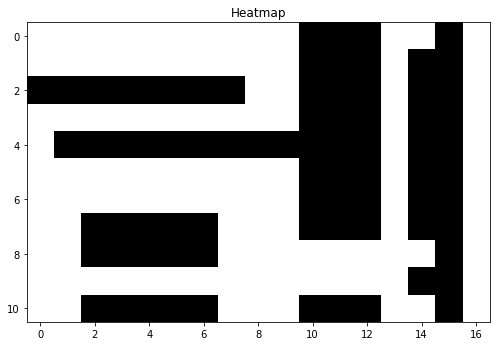

In [90]:
m = MCLmap([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]])

heatmap(m.m, cmap='binary')

Definamos el modelo de movimiento como una función `P_motion_sample`.

In [91]:
def P_motion_sample(kin_state, v, w):
    """Sample from possible kinematic states.
    Returns from a single element distribution (no uncertainity in motion)"""
    pos = kin_state[:2]
    orient = kin_state[2]

    # for simplicity the robot first rotates and then moves
    orient = (orient + w)%4
    for _ in range(orient):
        v = (v[1], -v[0])
    pos = vector_add(pos, v)
    return pos + (orient,)

Defina el modelo del sensor como una función `P_sensor`.

In [92]:
def P_sensor(x, y):
    """Conditional probability for sensor reading"""
    # Need not be exact probability. Can use a scaled value.
    if x == y:
        return 0.8
    elif abs(x - y) <= 2:
        return 0.05
    else:
        return 0

Inicializando variables.

In [93]:
a = {'v': (0, 0), 'w': 0}
z = (2, 4, 1, 6)

Ejecutemos `monte_carlo_localization` con estos parámetros para encontrar una distribución de muestra S.

In [94]:
S = monte_carlo_localization(a, z, 1000, P_motion_sample, P_sensor, m)

Tracemos los valores en la distribución de muestra "S".

GRID:
  0   0   12     0   143   14     0   0   0   0   0   0   0   0   0   0   0
  0   0    0     0    17   52   201   6   0   0   0   0   0   0   0   0   0
  0   0    0     0     0    0     0   0   0   0   0   0   0   0   0   0   0
  0   0    0     3     5   19     9   3   0   0   0   0   0   0   0   0   0
  0   0    0     0     0    0     0   0   0   0   0   0   0   0   0   0   0
  0   0    6   166     0   21     0   0   0   0   0   0   0   0   0   0   0
  0   0    0     1    11   75     0   0   0   0   0   0   0   0   0   0   0
 73   0    0     0     0    0     0   0   0   1   0   0   0   0   0   0   0
124   0    0     0     0    0     0   1   0   3   0   0   0   0   0   0   0
  0   0    0    14     4   15     1   0   0   0   0   0   0   0   0   0   0
  0   0    0     0     0    0     0   0   0   0   0   0   0   0   0   0   0


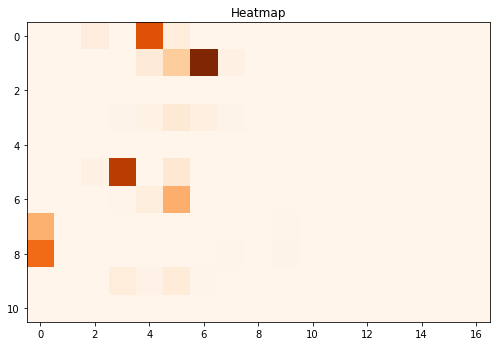

In [95]:
grid = [[0]*17 for _ in range(11)]
for x, y, _ in S:
    if 0 <= x < 11 and 0 <= y < 17:
        grid[x][y] += 1
print("GRID:")
print_table(grid)
heatmap(grid, cmap='Oranges')

La distribución está muy concentrada en "(5, 3)", pero el robot no está muy seguro de su posición ya que algunas otras celdas también tienen valores de probabilidad altos.

Veamos otro escenario.

GRID:
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0   1000   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0


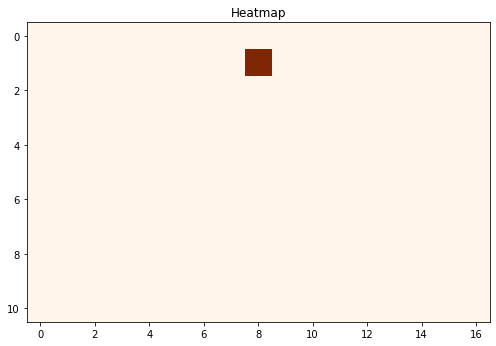

In [96]:
a = {'v': (0, 1), 'w': 0}
z = (2, 3, 5, 7)
S = monte_carlo_localization(a, z, 1000, P_motion_sample, P_sensor, m, S)
grid = [[0]*17 for _ in range(11)]
for x, y, _ in S:
    if 0 <= x < 11 and 0 <= y < 17:
        grid[x][y] += 1
print("GRID:")
print_table(grid)
heatmap(grid, cmap='Oranges')

En este caso, el robot tiene un 99,9% de seguridad de que está en la posición `(6, 7)`.

## AGENTE TEÓRICO DE DECISIÓN
Pasamos ahora al ámbito de la toma de decisiones probabilísticas.
<br>
Para elegir entre diferentes planes posibles en una determinada situación en un entorno determinado, un agente debe tener preferencia entre los posibles resultados de los distintos planes.
<br>
La __Teoría de la utilidad__ se utiliza para representar y razonar con preferencias.
El agente prefiere estados con una mayor _utilidad_.
Al construir sistemas de múltiples agentes, un elemento importante en el diseño es el mecanismo que utilizan los agentes para tomar decisiones sobre qué acciones adoptar para lograr sus objetivos.
Lo que normalmente se requiere es un mecanismo que garantice que las acciones adoptadas conduzcan a beneficios tanto para los agentes individuales como para la comunidad de la que forman parte.
La utilidad de un estado es relativa a la de un agente.
<br>
Las preferencias, expresadas por las utilidades, se combinan con las probabilidades en la teoría general de las decisiones racionales llamada __teoría de la decisión__.
<br>
Se dice que un agente es racional si y sólo si elige la acción que produce la mayor utilidad esperada, promediada sobre todos los resultados posibles de la acción.

Aquí veremos cómo se implementa un agente teórico de decisiones en el módulo.

In [97]:
psource(DTAgentProgram)

La función `DTAgentProgram` se explica por sí misma.
<br>
Encapsula una función "programa" que toma una observación o una "percepción", actualiza su "estado_creencia" y devuelve la acción que maximiza la "utilidad_resultado_esperado".

## AGENTE DE RECOPILACIÓN DE INFORMACIÓN
Antes de analizar qué es un agente de recopilación de información, necesitaremos saber qué son las redes de decisión.
Para un agente en un entorno, una red de decisión representa información sobre el estado actual del agente, sus posibles acciones, el estado que resultará de la acción del agente y la utilidad de ese estado.
Las redes de decisión tienen tres tipos principales de nodos que son:
1. __Nodos de probabilidad__: representan variables aleatorias, como en las redes bayesianas.
2. __Nodos de decisión__: Estos representan puntos donde quien toma las decisiones puede elegir entre diferentes acciones y el tomador de decisiones intenta encontrar la decisión óptima en estos nodos con respecto al costo, la seguridad y la utilidad resultante.
3. __Nodos de utilidad__: Representan la función de utilidad del agente.
Una descripción de la utilidad del agente como función está asociada con un nodo de utilidad.
<br>
<br>
Para evaluar una red de decisión, hacemos lo siguiente:
1. Inicializar las variables de evidencia según el estado actual.
2. Calcular las probabilidades posteriores para cada valor posible del nodo de decisión y calcular la utilidad resultante de esa acción.
3. Devuelve la acción con mayor utilidad.
<br>
Echemos un vistazo a la implementación de la clase `DecisionNetwork`.

In [98]:
psource(DecisionNetwork)

La clase `DecisionNetwork` hereda de `BayesNet` y tiene algunos métodos auxiliares adicionales.
<br>
`best_action` devuelve la mejor acción en la red.
<br>
`get_utility` es un método abstracto que se supone que devuelve la utilidad de una acción y un estado particulares en la red.
<br>
`get_expected_utility` calcula la utilidad esperada, dada una acción y evidencia.
<br>

Antes de continuar, necesitamos conocer algunos términos más.
<br>
Tener __información perfecta__ se refiere a un estado de plena conciencia del estado actual, las funciones de costos y los resultados de las acciones.
Esto, a su vez, permite al agente encontrar el valor de utilidad exacto de cada estado.
Si un agente tiene información perfecta sobre el medio ambiente, los cálculos de utilidad máxima esperada son exactos y pueden calcularse con absoluta certeza.
<br>
En la teoría de la decisión, el __valor de la información perfecta__ (VPI) es el precio que un agente estaría dispuesto a pagar para obtener acceso a la _información perfecta_.
Los cálculos de VPI se utilizan ampliamente para calcular las utilidades esperadas para los nodos en una red de decisión.
<br>
Para una variable aleatoria $E_j$ cuyo valor se desconoce actualmente, el valor de descubrir $E_j$, dada la información actual $e$ debe promediar todos los valores posibles $e_{jk}$ que podríamos descubrir para $E_j$, usando nuestro Creencias _actuales_ sobre su valor.
El VPI de $E_j$ viene dado por:
<br>
<br>
$$VPI_e(E_j) = \left(\sum_{k}P(E_j=e_{jk}\ |\ e) EU(\alpha_{e_{jk}}\ |\ e, E_j=e_{jk}) \right) - UE(\alpha\ |\ e)$$
<br>
VPI no es negativo, no aditivo y es independiente del orden.

Un agente de recopilación de información es un agente con ciertas propiedades que explora redes de decisión cuando sea necesario con heurísticas impulsadas por cálculos de VPI de nodos.
Un agente sensato debería hacer preguntas en un orden razonable, debería evitar hacer preguntas irrelevantes, debería tener en cuenta la importancia de cada dato en relación con su coste y debería dejar de hacer preguntas cuando sea apropiado.
_VPI_ se utiliza como heurística principal para considerar todos estos puntos en un agente de recopilación de información, ya que el agente en última instancia desea maximizar la utilidad y necesita encontrar el costo y el alcance óptimos para encontrar la información requerida.
<br>
A modo de descripción general, un agente de recopilación de información trabaja seleccionando repetidamente las observaciones con el mayor valor de información, hasta que el costo de la siguiente observación sea mayor que su beneficio esperado.
<br>
La clase `InformationGatheringAgent` es una clase abstracta que hereda de `Agent` y funciona según los principios discutidos anteriormente.
Echemos un vistazo.
<br>

In [99]:
psource(InformationGatheringAgent)

El método `costo` es un método abstracto que devuelve el costo de obtener la evidencia a través de pruebas, consultores, preguntas o cualquier otro medio.
<br>
El método `solicitud` devuelve el valor de la variable aleatoria dada como siguiente percepción.
<br>
El método `vpi_cost_ratio` devuelve una lista de VPI dividida por el costo para cada variable en la lista de `variables` que se le proporciona.
<br>
El método `vpi` calcula el VPI para una variable determinada
<br>
Y finalmente, el método "ejecutar" ejecuta el algoritmo general de recopilación de información, como se describe en la __figura 16.9__ del libro.
<br>
Nuestro agente implementa una forma de recopilación de información que se llama __miope__ ya que aquí la fórmula VPI se utiliza de manera miope.
Calcula el valor de la información como si solo se adquiriera una única variable de evidencia.
Esto es similar a la búsqueda codiciosa, donde no miramos el panorama más amplio y buscamos optimizaciones locales para, con suerte, alcanzar el óptimo global.
Esto a menudo funciona bien en la práctica, pero un agente miope podría tomar una acción apresuradamente cuando hubiera sido mejor solicitar más variables antes de tomar una acción.
Por otro lado, un _plan condicional_ podría funcionar mejor en algunos escenarios.
<br>


Con esto concluimos este cuaderno.